In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
import utilities.helpers as hp

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()

# ALL cases EDA:

# Import data set:

In [2]:
pd.options.mode.chained_assignment = None


df_full = hp.import_dataset(encoding='utf-8')
# Convert json to csv:
# df_full.to_csv('../data/dk_asylum_data_1.csv', encoding='utf-8', index=False)
df_full.shape

(9635, 5)

# Dataset preprocessing:

Keep ALL cases except for Unknown Homeland (Ukendt hjemland):

In [3]:
df_ALL = df_full[df_full.country != "Ukendt hjemland"]

# Drop redundant column:
df_ALL.drop('hasText', axis=1, inplace=True)

df = df_ALL

df["text"] = df["text"].astype("string")

df.shape

(9443, 4)

In [4]:

df.head()

,id,asylum_motive,country,text
0,0,"[Statusændring, Privatretlig forhold, Øvrige...",Syrien,Nævnet omgjorde i maj 2022 Udlændinges...
1,1,"[To-instansbehandling, Bortfald]",Syrien,Nævnet hjemviste i november 2021 Udlæn...
2,2,"[Statusændring, Militære forhold]",Eritrea,Nævnet omgjorde i maj 2022 Udlændinges...
3,3,"[Generelle forhold, Privatretlig forhold]",Afghanistan,Nævnet stadfæstede i maj 2022 Udlændin...
4,4,"[Kriminelle forhold, Privatretlig forhold, S...",Afghanistan,Nævnet stadfæstede i maj 2022 Udlændin...


Check for potential duplicates and drop them:

In [5]:
duplicates_df = df[df.duplicated(['text'], keep='last')]
#pd.concat(g for _, g in df.groupby("text") if len(g) > 1)

# See all duplicates:
duplicates_df

,id,asylum_motive,country,text
131,131,"[Generelle forhold, Øvrige modsætningsforhold...",Syrien,Nævnet omgjorde i november 2021 Udlænd...
132,132,"[Generelle forhold, Øvrige modsætningsforhold...",Syrien,Nævnet omgjorde i november 2021 Udlænd...
521,521,"[Udsendelse (§ 49 a m.v.), Sur Place, Privat...",Afghanistan,Nævnet stadfæstede i juli 2021 Udlændi...
1098,1098,"[Konsekvensstatus, Statusændring, Politiske ...",Syrien,Nævnet meddelte i oktober 2020 opholds...
1142,1142,"[Seksuelle forhold, Overgreb, Etniske forhol...",Den Demokratiske Republik Congo (DR Congo),Nævnet stadfæstede i september 2020 Ud...
...,...,...,...,...
9388,9388,"[Politiske forhold, Agents of Persecution, T...",Afghanistan,Nævnet meddelte i juli 2010 opholdstilladelse ...
9582,9582,[Politiske forhold],Afghanistan,Nævnet stadfæstede i juni 2005 Udlændi...
9594,9594,[Privatretlig forhold],Afghanistan,Nævnet stadfæstede i december 2005 Udl...
9602,9602,[Politiske forhold],Afghanistan,Nævnet stadfæstede i april 2004 en afg...


See shape of new data frame:

In [6]:
# Drop duplicates from original dataframe based on text column
# If the summary is the same probalbly were are looking at a duplicate
# without taking into account all other variables(columns):
df = df.drop_duplicates('text', keep='last')
# Check shape again:
df.shape

(8963, 4)

## Length of texts

Create a numeric column in order to get a feel about the length of the texts. 

In [7]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8963.0,4825.259846,2830.033440,0.0,2307.5,4858.0,7343.5,9634.0
length,8963.0,4159.678456,2212.306528,407.0,2636.0,3771.0,5153.5,24044.0


## Boxplot:

<AxesSubplot:>

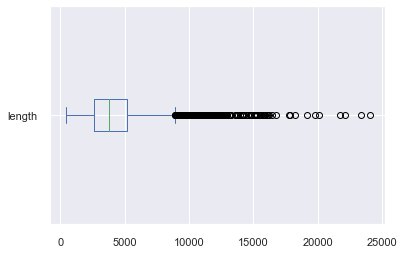

In [8]:
# Box plot:
df['length'].plot(kind='box', vert=False)

# Text Processing:

Column `text` is processed in order to extract data concerning:
- decision outcome
- gender of applicants
- year of decision

Steps included in the pipeline:
- lower casing
- punctuation removal
- stopword removal
- single letter word removal
- tokenization
- lemmatization

In [9]:
pipeline = [str.lower, hp.remove_punctuation, hp.remove_stopwords, hp.drop_single_letter_words,
            hp.tokenize, hp.lemmatize]

In [10]:
# Apply the process:
df['tokens'] = df['text'].apply(hp.process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

See ten first entries

In [11]:
df.head(10)

,id,asylum_motive,country,text,length,tokens,num_tokens
0,0,"[Statusændring, Privatretlig forhold, Øvrige...",Syrien,Nævnet omgjorde i maj 2022 Udlændinges...,7751,"[omgjorde, 2022, udlændingestyrels, afgørelse,...",600
1,1,"[To-instansbehandling, Bortfald]",Syrien,Nævnet hjemviste i november 2021 Udlæn...,2009,"[hjemvise, 2021, udlændingestyrels, afgørelse,...",147
2,2,"[Statusændring, Militære forhold]",Eritrea,Nævnet omgjorde i maj 2022 Udlændinges...,2670,"[omgjorde, 2022, udlændingestyrels, afgørelse,...",196
3,3,"[Generelle forhold, Privatretlig forhold]",Afghanistan,Nævnet stadfæstede i maj 2022 Udlændin...,6695,"[stadfæste, 2022, udlændingestyrels, afgørelse...",573
4,4,"[Kriminelle forhold, Privatretlig forhold, S...",Afghanistan,Nævnet stadfæstede i maj 2022 Udlændin...,11359,"[stadfæste, 2022, udlændingestyrels, afgørelse...",899
5,5,"[Politiske forhold, Privatretlig forhold]",Rwanda,Nævnet stadfæstede i maj 2022 Udlændin...,7232,"[stadfæste, 2022, udlændingestyrels, afgørelse...",471
6,6,"[Inddragelse/forlængelse, Privatretlig forhold]",Afghanistan,Nævnet omgjorde i maj 2022 Udlændinges...,4902,"[omgjorde, 2022, udlændingestyrels, afgørelse,...",355
7,7,"[Øvrige modsætningsforhold til myndighederne, ...",Syrien,Nævnet omgjorde i maj 2022 Udlændinges...,6470,"[omgjorde, 2022, udlændingestyrels, afgørelse,...",442
8,8,"[Udsendelse (§ 49 a m.v.), Militære forhold, ...",Iran,Nævnet stadfæstede i maj 2022 Udlændin...,4017,"[stadfæste, 2022, udlændingestyrels, afgørelse...",302
9,9,"[Dublin, Artikel 18 (Den ansvarlige medlemsst...",Tyskland,Nævnet stadfæstede i april 2022 Udlænd...,3971,"[stadfæste, 2022, udlændingestyrels, afgørelse...",288


# Country of Origin:

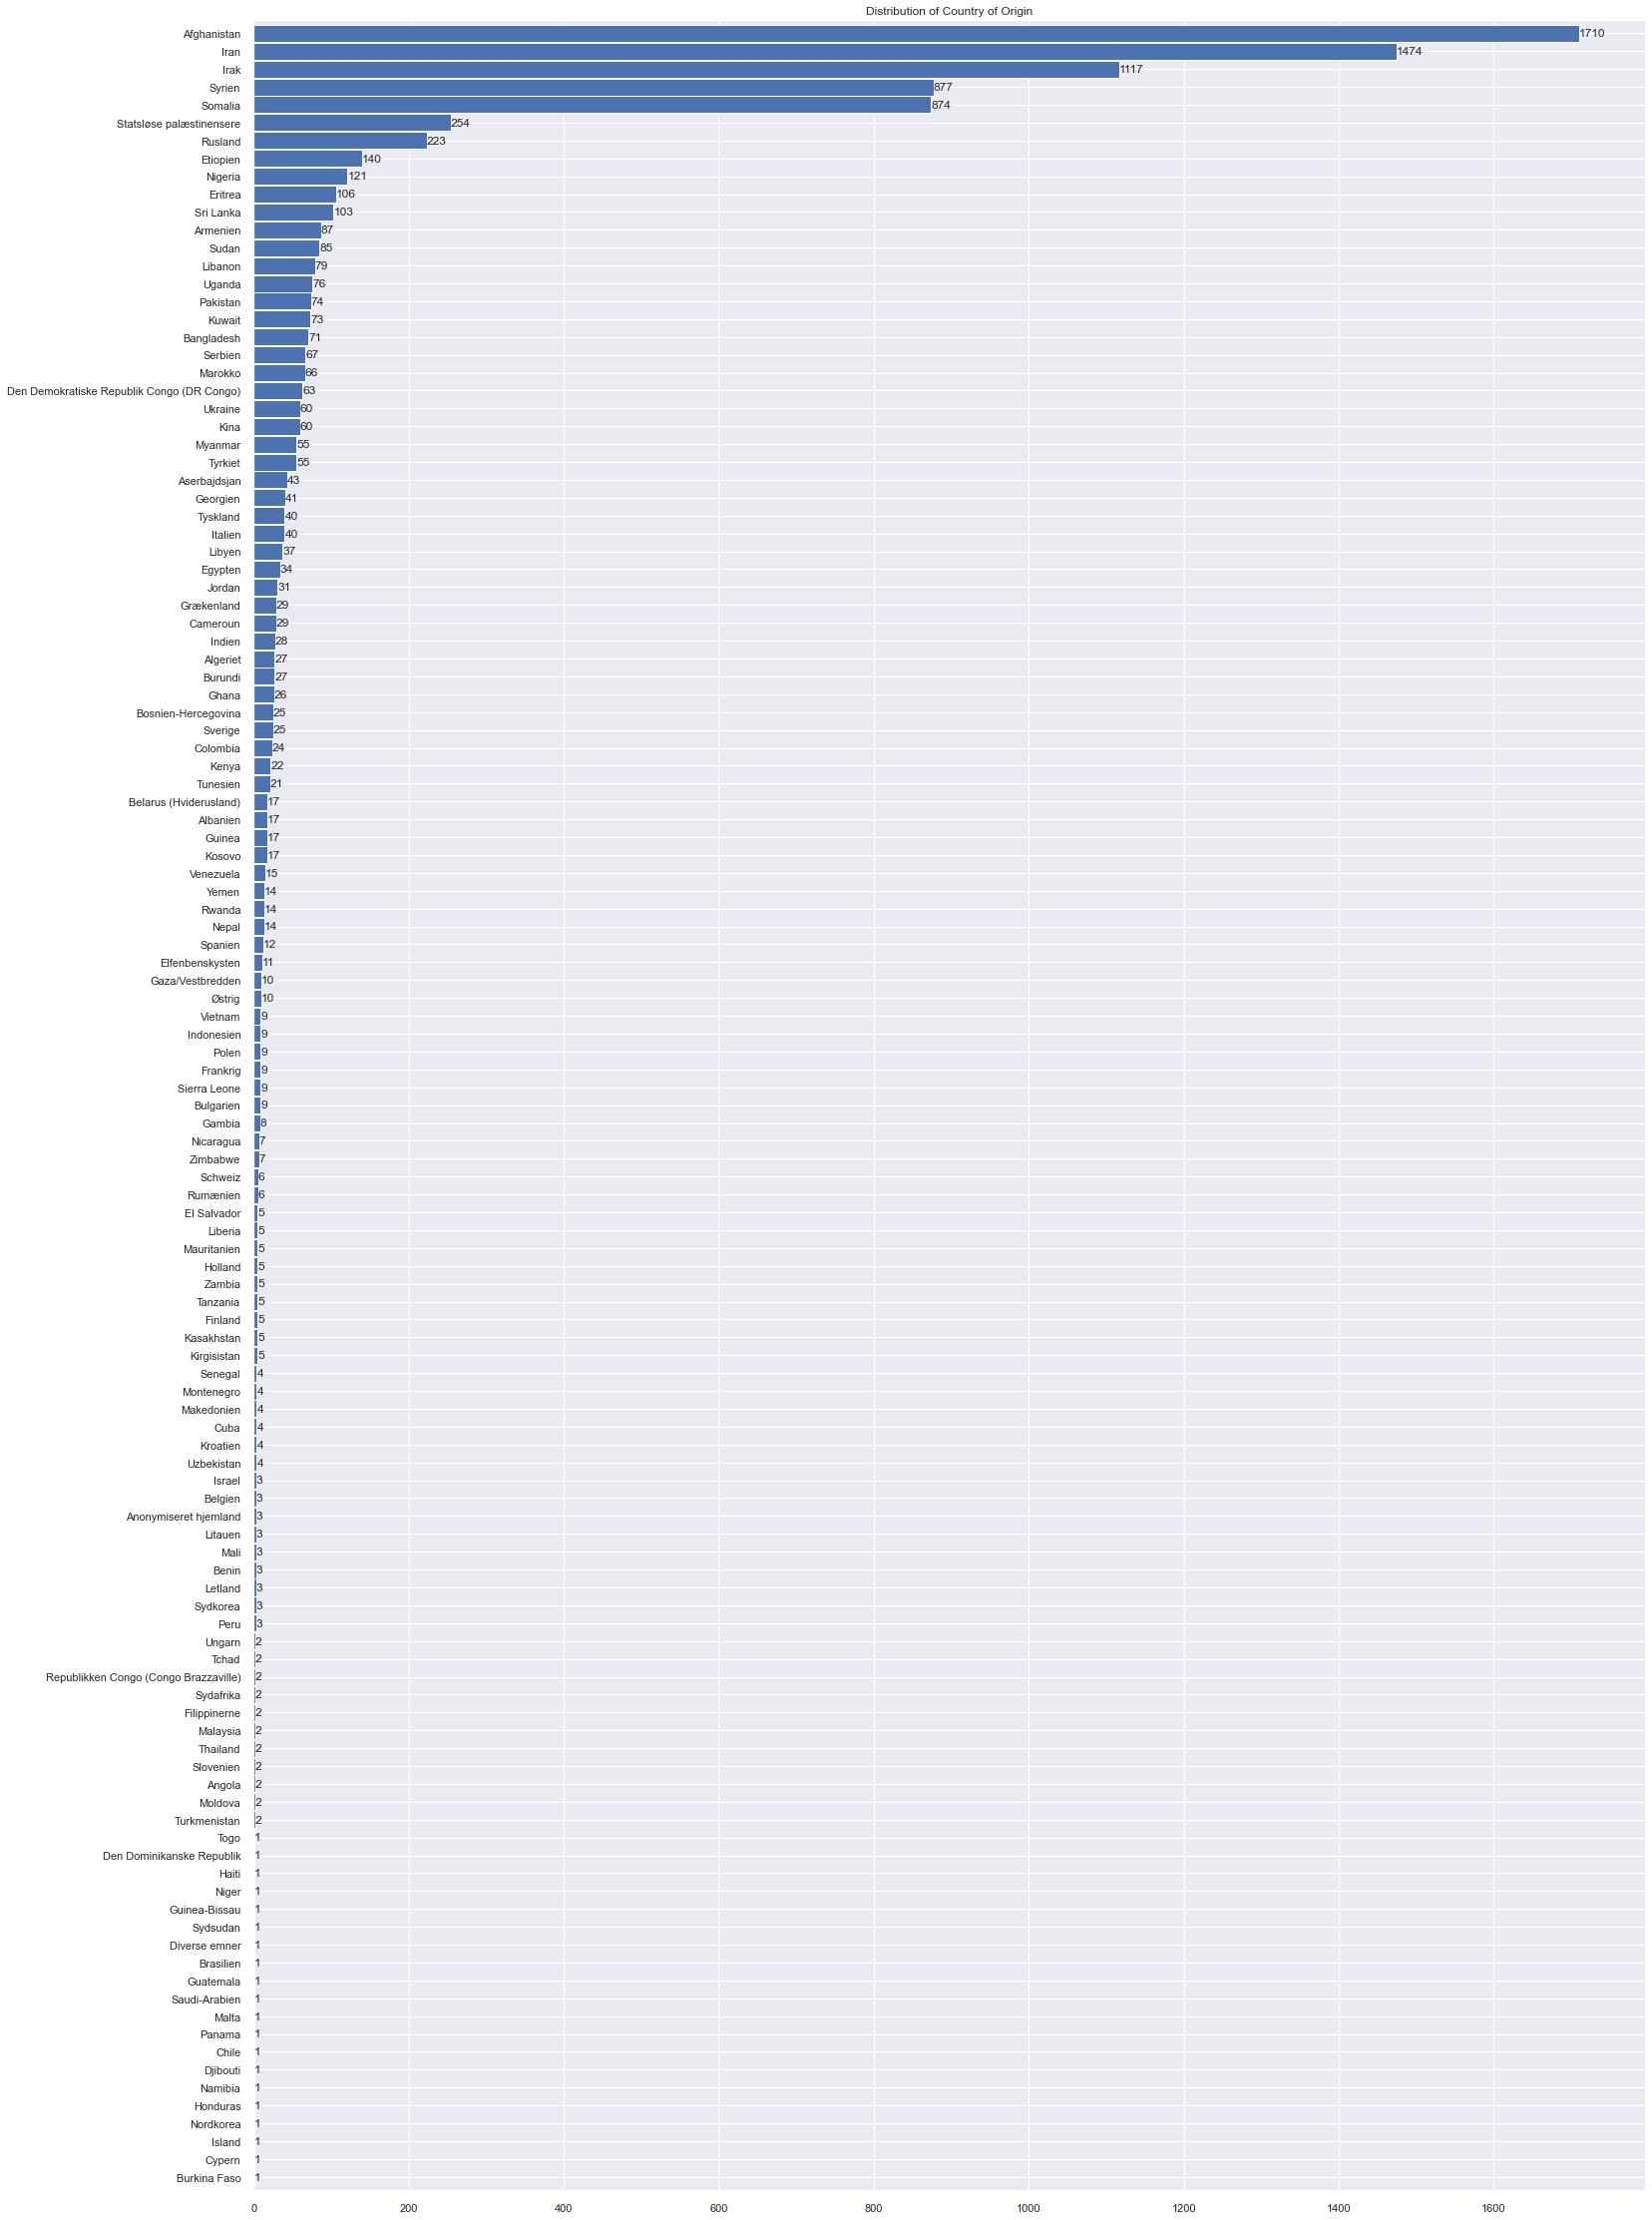

In [12]:
df_country_nan = df['country'].replace(r'^\s*$', np.nan, regex=True) # replace empty string with nan
df_country_nan = df_country_nan.dropna() # remove nan
ax = df_country_nan.value_counts()[:].plot(kind='barh', title='Distribution of Country of Origin', rot=0, width=0.95, figsize=(25, 40))
ax.invert_yaxis()


for container in ax.containers:
    ax.bar_label(container)

# Decision extraction:

In [13]:
df['tokens_joined'] = [' '.join(token) for token in df['tokens']]

In [14]:
df_stad = df['tokens_joined'].str.contains('stadfæst.*?', regex=True) # affirmed decision of Immigration Services
df_hem = df['tokens_joined'].str.contains('hjemvis.*?', regex=True) # overturned decision of Immigration Services
df_med = df['tokens_joined'].str.contains('meddel.*?', regex=True) # overturned decision of Immigration Services
df_omg = df['tokens_joined'].str.contains('omgjor.*?|omgør.*?', regex=True) # overturned decision of Immigration Services
df_ame = df['tokens_joined'].str.contains('ændr.*?', regex=True) # overturned decision of Immigration Services
df_oph = df['tokens_joined'].str.contains('ophæv.*?', regex=True) # overturned decision of Immigration Services

df['decision'] = np.where(df_stad, 'affirmed', np.where(df_hem | df_med | df_omg | df_ame | df_oph, 'overturned', np.nan))

Plot decision:

Text(0, 0.5, 'outcomes')

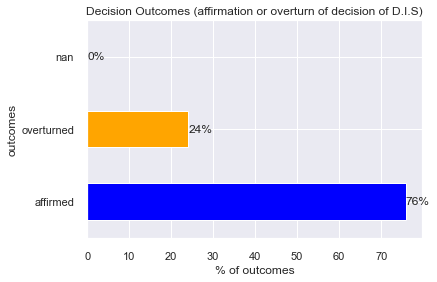

In [15]:
colors = ['blue', 'orange']

# Plot with normalized values:
ax = df['decision'].value_counts(normalize=True).mul(100).round(1).plot(
    kind='barh', color=colors, title='Decision Outcomes (affirmation or overturn of decision of D.I.S)')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
ax.set_xlabel('% of outcomes')
ax.set_ylabel('outcomes')

# plt.savefig("dataset-bigram.png")

# Uncomment to plot frequencies:
# ax = df['decision'].value_counts().plot(
#     kind='barh', color=colors, title='Decision Outcomes for Unknown Homeland')
# ax.bar_label(container)


Plot decision outcome rate by country:

In [55]:
countries = df.groupby(df['country'])['decision'].value_counts(dropna=False)

countries.to_frame('count')

count
country     decision         
            affirmed       39
            overturned     11
Afghanistan affirmed     1271
            overturned    439
Albanien    affirmed       14
...                       ...
Zambia      affirmed        3
            overturned      2
Zimbabwe    overturned      4
            affirmed        3
Østrig      affirmed       10

[187 rows x 1 columns]

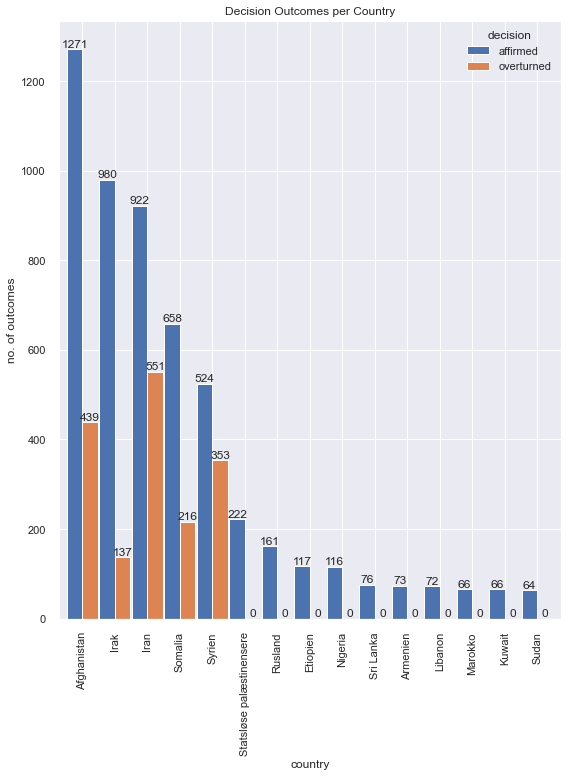

In [45]:
ax = df.groupby(df['country'])['decision'].value_counts().sort_values(ascending=False).iloc[:20].unstack().plot(
    kind='bar', title='Decision Outcomes per Country', rot=90, width=0.95, figsize=(9, 11))
# ax.invert_yaxis()
ax.set_ylabel('no. of outcomes')
# ax.set_ylabel('country')

for container in ax.containers:
    ax.bar_label(container)


# Gender of applicants extraction:

In [17]:
male_pat = 'mandl.*?statsborg.*?|mand.*?ansøg.*?|mand.*?klag.*?'
female_pat = 'kvinde.*?statsborg.*?|kvinde.*?ansøg.*?|kvinde.*?klag.*?'
couple_pat = 'ægtepar.*?'

df_female = df['text'].str.contains(female_pat)
df_male = df['text'].str.contains(male_pat)
df_couple = df['text'].str.contains(couple_pat)

df['gender'] = np.where(df_male, "male", np.where(df_female, "female", np.where(df_couple, 'couples', 'unidentified')))


Text(0, 0.5, 'nn. of outcomes')

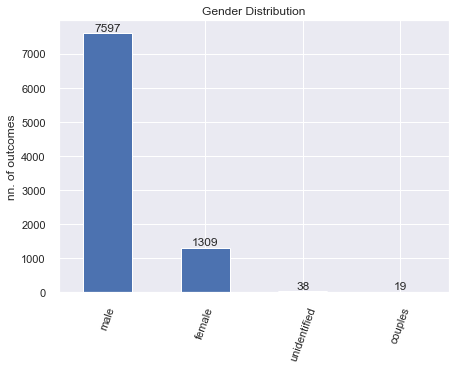

In [18]:
ax = df['gender'].value_counts().plot(kind='bar', rot=70, title='Gender Distribution', figsize=(7,5))

for container in ax.containers:
    ax.bar_label(container)
ax.set_ylabel('nn. of outcomes')
# ax.set_ylabel('gender')


# Year of decision:

In [19]:
df['year'] = df['tokens_joined'].str.extract(r'(\d{4})') # match 4 four digits that appear in string 

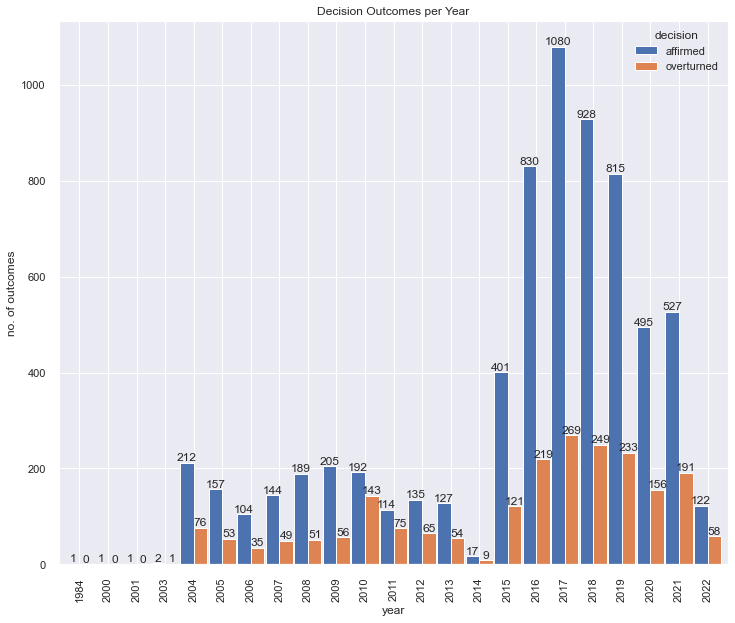

In [48]:
ax = df.groupby(df['year'])['decision'].value_counts().unstack().plot(
    kind='bar', title='Decision Outcomes per Year', figsize=(12,10), width=0.95)
ax.set_xlabel('year')
ax.set_ylabel('no. of outcomes')

for container in ax.containers:
    ax.bar_label(container)

Plot Decision Outcome Frequencies by Gender for each Year:

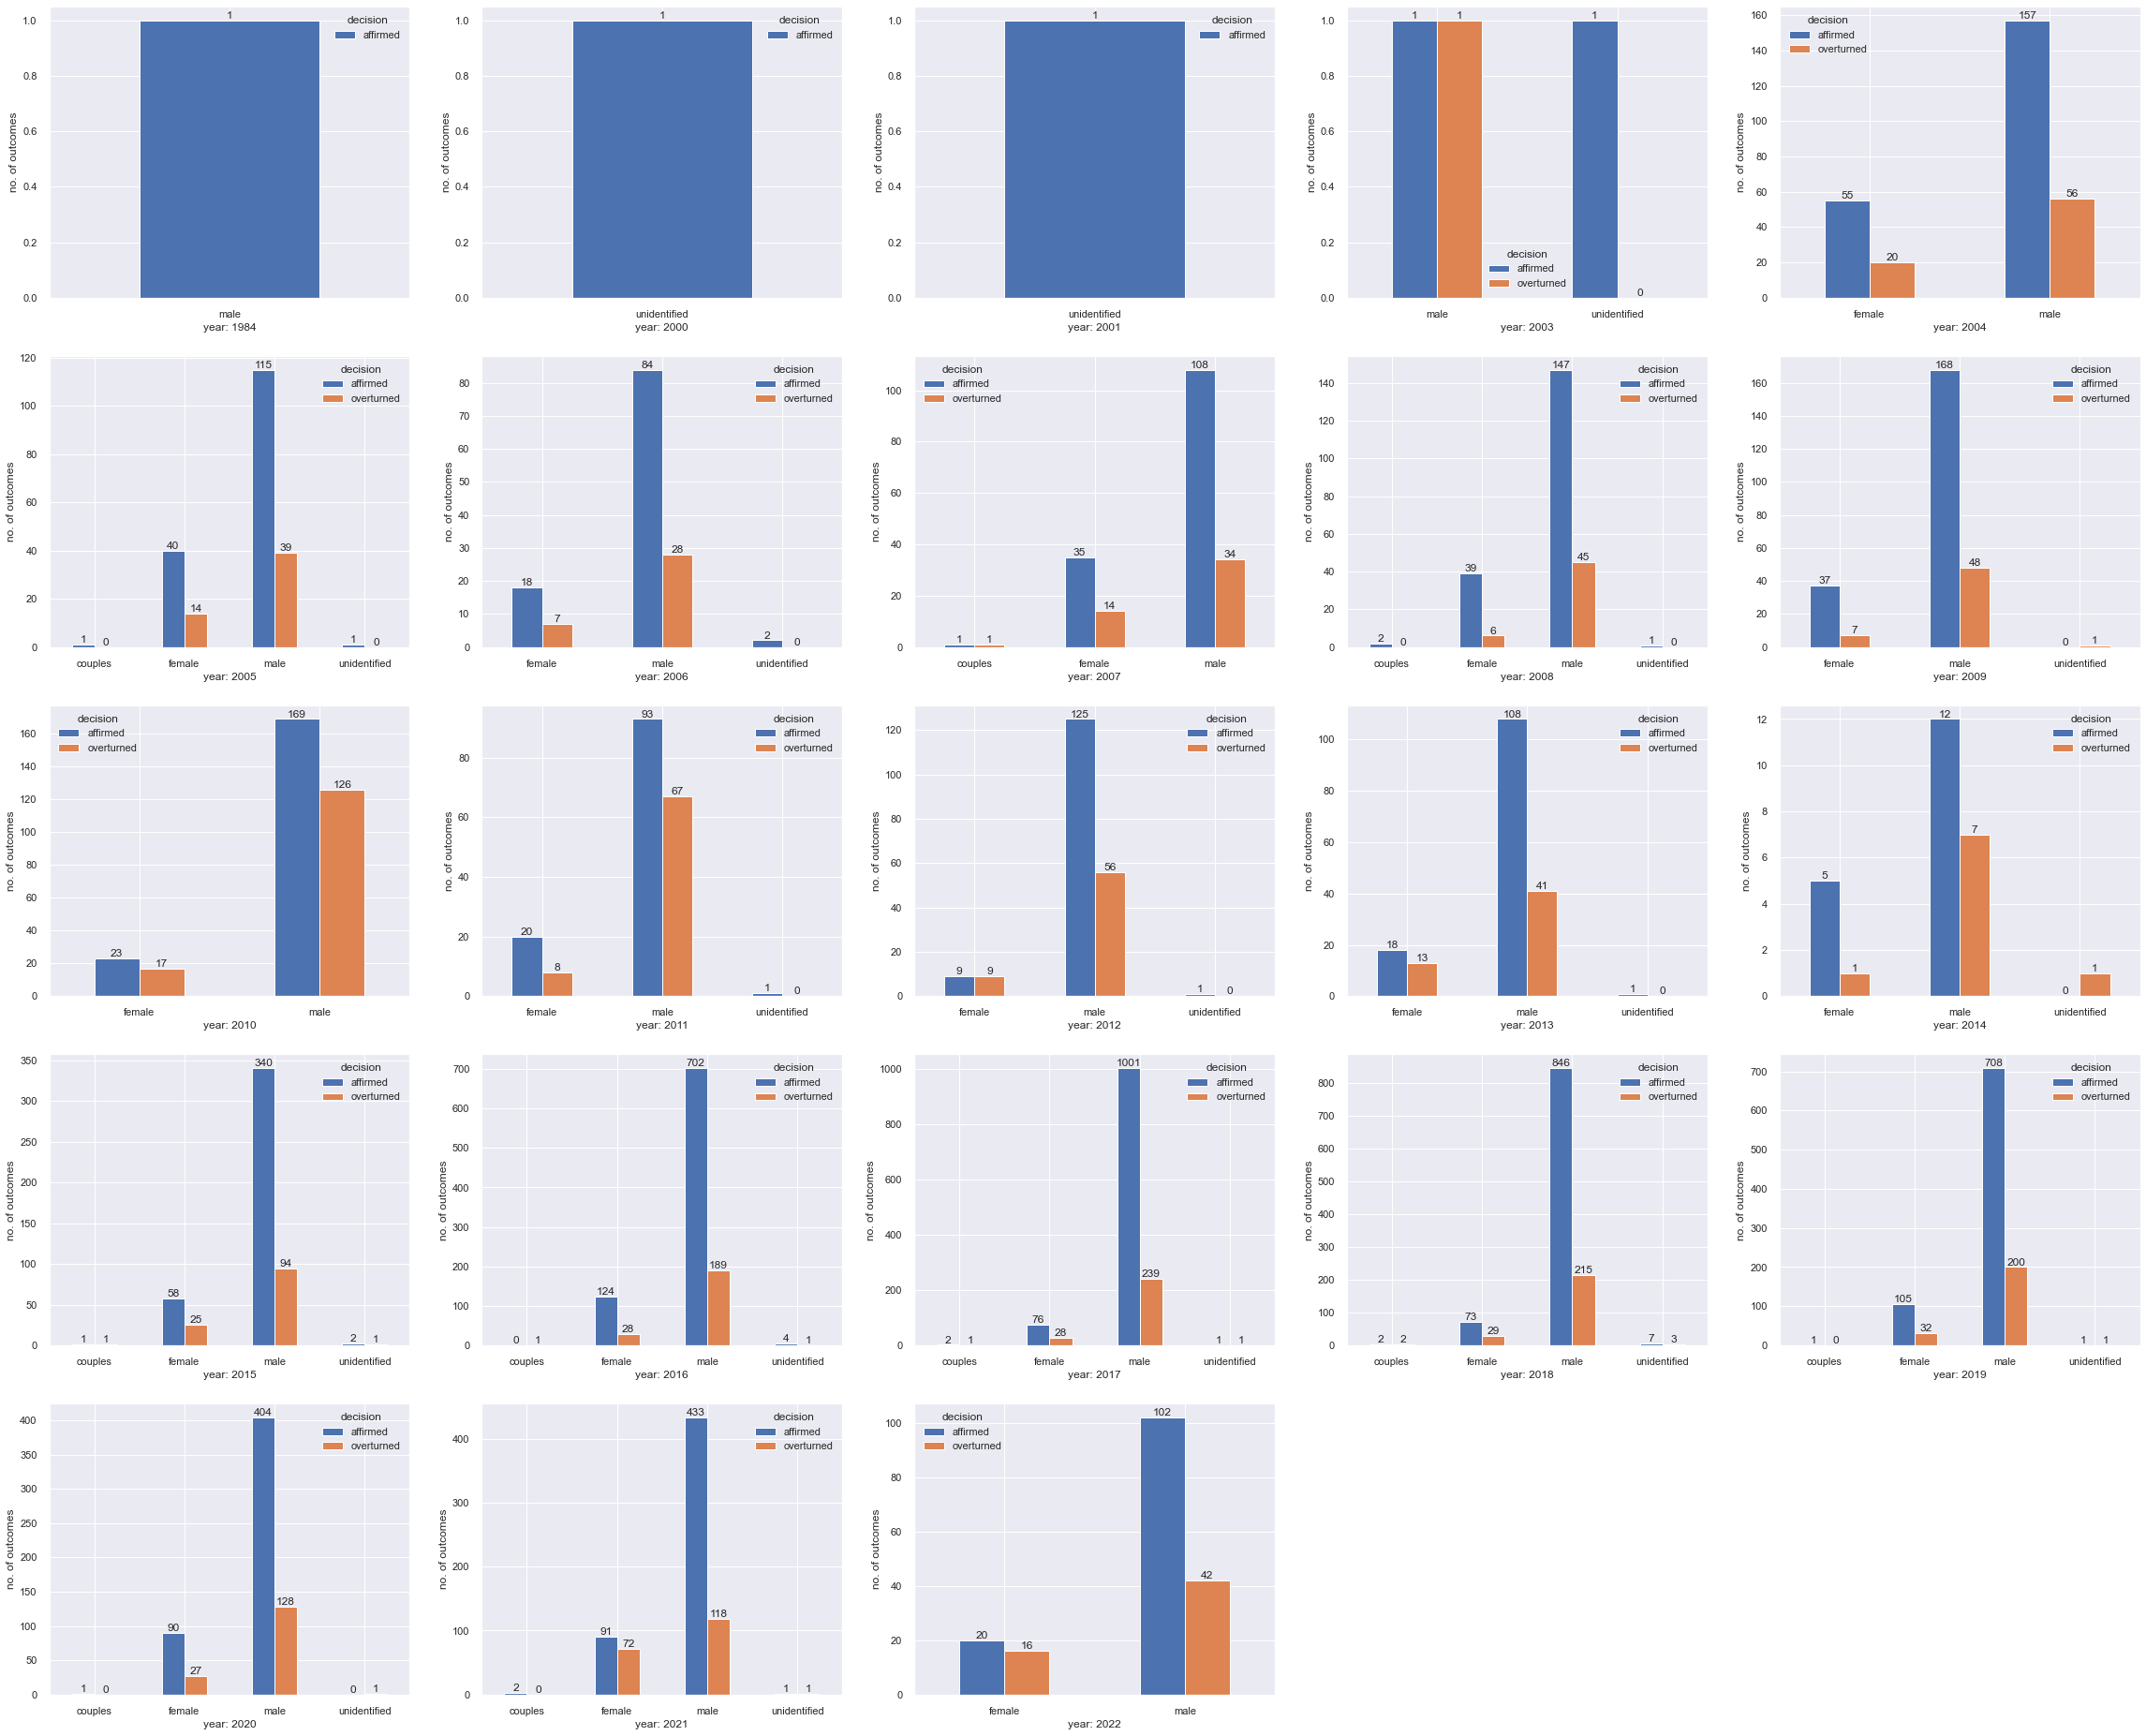

In [21]:
# Uncomment to plot separate figures:
# for year in df['year'].unique():
#     ax = df[df.year==year].groupby(['gender'])['decision'].value_counts().unstack().plot(
#     kind='bar', title='Decision Outcomes by Gender for Unknown Homeland for '+ str(year))
#     ax.set_xlabel('gender')
#     ax.set_ylabel('no. of outcomes')

#     for container in ax.containers:
#         ax.bar_label(container)

# Plot all figures in one
plt.figure(figsize=(40, 40))
for ix, (key, group) in enumerate(df.groupby('year')):
    ax = plt.subplot(6, 5, ix+1, autoscale_on=True)
    group.groupby('gender')['decision'].value_counts().unstack().plot(kind='bar', rot=0, ax=ax)
    ax.set_xlabel('year: {}'.format(key))
    ax.set_ylabel('no. of outcomes')
    for container in ax.containers:
        ax.bar_label(container)

# Asylum motives distribution:

In [22]:

df['asylum_motive'] = df['asylum_motive'].astype("string")

df_motives = df['asylum_motive'].str.split(',').explode().str.strip('[\'\'] ').value_counts()

df_motives


Agents of Persecution                                         2383
Politiske forhold                                             2365
Privatretlig forhold                                          1853
Generelle forhold                                             1838
Religiøse forhold                                             1355
                                                              ... 
Artikel 3                                                        2
Pas-sager                                                        1
TagCollectionMotive                                              1
Artikel 9 (familiemedlemmer med international beskyttelse)       1
Artikel 8 (uledsagede mindreårige)                               1
Name: asylum_motive, Length: 65, dtype: int64

Plot ten most frequent asylum motives:

Text(0, 0.5, 'frequency')

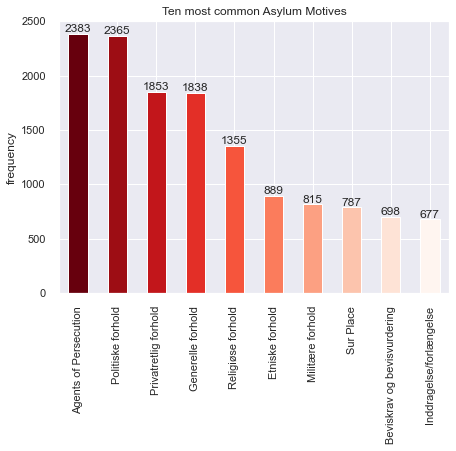

In [23]:
gradient_colors = cm.Reds(np.linspace(1, 0, 10))


ax = df_motives.iloc[:10].plot(kind='bar', color=gradient_colors,
                               rot=90, title='Ten most common Asylum Motives', figsize=(7, 5))

for container in ax.containers:
    ax.bar_label(container)
ax.set_ylabel('frequency')


# Search for specific terms:

- Bidoon:

In [24]:
df['bidoon'] = df['tokens_joined'].str.extract(r'(bidoo.?)', hp.re.IGNORECASE)
df['bidoon'].value_counts()

bidoon    86
Bidoon     2
Name: bidoon, dtype: int64

Merge categories and count again:

In [25]:
df['bidoon'] = df['bidoon'].replace('Bidoon', 'bidoon')
df['bidoon'].value_counts()

bidoon    88
Name: bidoon, dtype: int64

See some context:

In [26]:
hp.kwic(df['text'], 'bidoon', print_samples=10)

10 random samples out of 467 contexts for 'bidoon':
irer i Irak og/eller Kuwait. Nævnet forkaster derfor ansøgernes forklaringer om, at de er statsløse  bidoon ere fra Kuwait som utroværdig. Det bemærkes i den forbindelse videre, at ingen af ansøgerne har haft
stadfæstede i juli 2021 Udlændingestyrelsens afgørelse vedrørende en mandlig asylansøger angiveligt  bidoon  Kuwait. Indrejst 2016.”Ansøgeren er, den angiveligt statsløse bidoon fra Kuwait og som er etnisk ar
    Nævnet stadfæstede i oktober 2018 Udlændingestyrelsens afgørelse vedrørende en mandlig statsløs  bidoon  fra Kuwait. Indrejst i 2015. Flygtningenævnet udtalte: ”Ansøgeren er etnisk araber og sunni-muslim 
ait samt parrets tre børn. Indrejst i 2015.Flygtningenævnet udtalte:”Ansøgerne har oplyst, at de er  bidoon s (statsløse) fra Suleibiyeh, Kuwait, etniske arabere og shia-muslimer af trosretning. Ansøgerne har
ner i Kuwait, der er årsag til hans udrejse. Det fremgår af baggrundsoplysninger om situationen for  bidoon er i

Decision outcomes for bidooners outside Unknown Homeland.

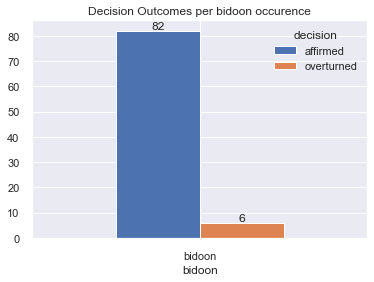

In [27]:
ax = df.groupby('bidoon')['decision'].value_counts().unstack().plot(
    kind='bar', title='Decision Outcomes per bidoon occurence', rot=0)
# ax.set_xlabel('bidoon')
# ax.set_ylabel('no. of outcomes')

for container in ax.containers:
    ax.bar_label(container)